<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Goals" data-toc-modified-id="Learning-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Learning Goals</a></span></li><li><span><a href="#Context" data-toc-modified-id="Context-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Context</a></span></li><li><span><a href="#Boundary-conditions" data-toc-modified-id="Boundary-conditions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Boundary conditions</a></span></li><li><span><a href="#1D-diffusion-from-a-constant-concentration-boundary" data-toc-modified-id="1D-diffusion-from-a-constant-concentration-boundary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>1D diffusion from a constant-concentration boundary</a></span></li><li><span><a href="#1D" data-toc-modified-id="1D-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1D</a></span></li><li><span><a href="#Quantification-of-the-error" data-toc-modified-id="Quantification-of-the-error-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Quantification of the error</a></span></li><li><span><a href="#2D" data-toc-modified-id="2D-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>2D</a></span></li></ul></div>

# 2D Transient simulation

## Learning Goals

- Being able to perform a 2D diffusion problem with inhomogeneous diffusion
- Being able to assess the accuracy by comparing solution of a homogeneous problem to an analyitical solution
- Being able to define the gridsize and timesteps to have reasonable computation time vs accuracy
- Use the precedent approach to model a more complicated problem

## Context

We want to study the diffusion of a contaminant in a geological context. The different geological layers and zones induce that the diffusion is not the same in every direction. We want to model these effects that diffusion is stopped on some boundary, that diffusion avoids certain areas of low diffusivity, ...

To start that, we need a transient 2D model whose parameters are well defined. In order to assess the accuracy of the method, we will start by using the approach on simple cases for which an analytical solution is known. That will allow to define the timestep, gridsize, to have a reasonable agreement with analytical solution.

From then, we will be able to model any similar situation.

## Boundary conditions

Different types of boundary conditions can be encountered. So far, we have only used a boundary condition specifying the value of the unknown at one point (these are called Dirichlet boundary condition). In some case, a flux  is specified as a boundary condition, e.g. a certain amount of water/gas is injected at one boundary at a rate of 1 kg/s. These conditions will specify the derivative of the unknowns.

A usual boundary condition is a no-flux boundary condition, meaning the solutes cannot go through a boundary. No diffusive flux means that the difference in concentration is zero. Thus, it specifies a zero-derivative at the boundary. Physically, this represents particle bouncing on a reflecting surface: every particle colliding with the surface is reflected back. Therefore, zooming on the boundary, the derivative of the concentration is zero.

## Transient diffusion from a constant-concentration boundary

Let us describe the diffusion of a contaminant in soils where a constant concentration is applied at onne boundary. It can be shown that the analytical solution to such a problem can be represented by the following equation:

\begin{equation}
c(x,t) = c_0  \text{erfc}\left( \frac{x}{\sqrt{4Dt}}  \right)
\end{equation}

where erfc$(x)$ is the error function. Let us look at this solution for different timesteps.


In [14]:
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import special
from numpy.testing import assert_allclose

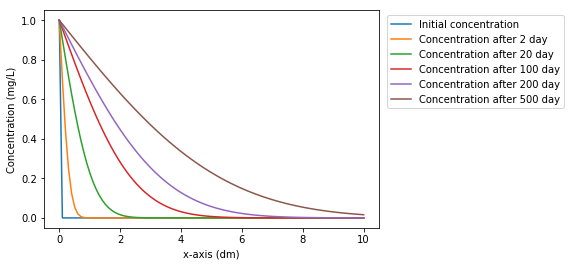

In [15]:
N_tstep = 6
Days_of_Plot = [0, 2, 20, 100, 200, 500]

N_x = 100
Width = 10
x = np.linspace(0, Width, N_x)
Analytic_conc_1D = np.zeros((N_tstep, N_x))
a = 1
c0 = 1
Diff = 2e-9 * 100 * 24 * 3600
Analytic_conc_1D[0, 0] = c0

plt.plot(x, Analytic_conc_1D[0, :], label="Initial concentration")

for t in range(1, N_tstep):
    for i in range(N_x):
        DENOM = np.sqrt(4 * Diff * Days_of_Plot[t])
        Analytic_conc_1D[t, i] = c0 * special.erfc((x[i]) / DENOM)
    plt.plot(x, Analytic_conc_1D[t, :], label="Concentration after %.0f day" % Days_of_Plot[t])


plt.xlabel("x-axis (dm)")
plt.ylabel("Concentration (mg/L)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
# noqa

If we consider a 2D system, without any heterogeneity along the y-axis, the previous solution is valid for each y axis, and you can imagine that the previous plot is a transverse vision of the evolution of the front. This means that, whatever the value of  $y$:

\begin{equation}
  c(x,y_1,t) = c(x,y_2,t) \quad \forall y_1,y_2,x,t
\end{equation}

In the next few cells, we define some function which we will use throughout the rest of the assignment.

- avg(Di,Dj) computes the average diffusion coefficient to compute the flux between two cells with different D
- ind_to_row_col(...) function to know which column and which row correspond to which index
- Build_2D_Matrix(...) is the same function than before, generalized to 2D and multiple boundary conditions

Then we have defined two classes (objects) which will store informations to make it easier to pass to functions.

- class boundary: creates a boundary which has a type and an assigned value ("const" means constant-concentration boundary, and its attribute "val" is the value of this concentration. otherwise, it is a flux boundary condition, and the attribute "0" expresses the derivative at that boundary).
- class def_prob: puts every relevant parameter in an object to be given to Build_2d_Matrix

In [16]:
# this function deals with harmonic averaging when diffusion is not the same everywhere.
# It doesn't change anything when diffusion is homogeneous but you can try to see how it affects the behavior.


def avg(Di, Dj):
    """
    Computes the harmonic average between two values Di and Dj
    Returns 0 if either of them is zero
    """
    if (Di * Dj) == 0:
        return 0
    else:
        return 2 / (1 / Di + 1 / Dj)

In [17]:
def ind_to_row_col(ind, nrows, ncol):
    """
    in a 2D array, returns the row and column value
    associated with a certain index
    Bottom left is index is zero (0-th row, 0-th column)
    while index one is the 0-th row and 1st column
    """
    if ind > nrows * ncol - 1:
        return 0

    row = int(np.floor(ind / ncol))
    col = int(ind - row * ncol)
    return row, col

In [18]:
def Build_2D_Matrix(BC, Prob, D, Q):
    """
    Constructs a coefficient matrix A and an array b corresponding to the system Ac = b
    This system corresponds either to a 1D or 2D problem
    Parameters:
    --------------
    BC: contains boundary objects defining the boundary conditions
    nx (int): amounts of cells on the x-axis
    ny (int): amount of cells on the y-axis
    D (float array): values of the diffusion coefficient at each grid point(dm^2/day)
    Width_X (float): x-extent of the domain
    Width_Y (float): y-extent of the domain
    poro (float): porosity value
    Q (float array): volumetric source term (mg/L/day)
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b

    ----------
    """
    Number_of_rows = Prob.ny
    Number_of_col = Prob.nx
    n = Prob.nx * Prob.ny
    is1D = False
    if Number_of_rows == 1 or Number_of_col == 1:
        is1D = True
        Number_of_col = n
    Matrix = np.zeros((n, n))
    RHS = np.zeros(n)

    if is1D:
        dx = max(Prob.Wx, Prob.Wy) / (max(Prob.ny, Prob.nx) - 1)
        coef_x = Prob.poro / dx / dx
    else:
        dx = Prob.Wx / (Prob.ny - 1)
        dy = Prob.Wy / (Prob.nx - 1)
        coef_x = Prob.poro / dx / dx
        coef_y = Prob.poro / dy / dy

    for ind in range(n):
        if is1D:
            j = ind
            i = -1
        else:
            i, j = ind_to_row_col(ind, Number_of_rows, Number_of_col)
        if j == 0:  # WEST BOUNDARY
            if BC["west"].btype == "const":
                RHS[ind] = BC["west"].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind + 1] = -1
                RHS[ind] = BC["west"].val / dx

        elif j == Number_of_col - 1:  # EAST BOUNDARY
            if BC["east"].btype == "const":
                RHS[ind] = BC["east"].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind - 1] = -1
                RHS[ind] = BC["east"].val / dx
        elif i == 0 and Prob.ny > 1:  # SOUTH BOUNDARY
            if BC["south"].btype == "const":
                RHS[ind] = BC["south"].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind + Number_of_col] = -1
                RHS[ind] = BC["south"].val / dy

        elif i == Number_of_rows - 1 and Prob.ny > 1:  # NORTH BOUNDARY
            if BC["north"].btype == "const":
                RHS[ind] = BC["west"].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind - Number_of_col] = -1
                RHS[ind] = BC["north"].val / dy
        else:
            if is1D:
                North = 0
                South = 0
                RHS[ind] = Q[ind]
                East = coef_x * avg(D[ind + 1], D[ind])
                West = coef_x * avg(D[ind - 1], D[ind])
            else:
                North = coef_y * avg(D[i, j], D[i + 1, j])
                South = coef_y * avg(D[i, j], D[i - 1, j])
                East = coef_x * avg(D[i, j], D[i, j + 1])
                West = coef_x * avg(D[i, j], D[i, j - 1])
                Matrix[ind, ind + Number_of_col] = -North
                Matrix[ind, ind - Number_of_col] = -South
                RHS[ind] = Q[i, j]

            Matrix[ind, ind] = East + West + North + South
            Matrix[ind, ind + 1] = -East
            Matrix[ind, ind - 1] = -West

    return Matrix, RHS

In [19]:
class boundary:
    btype: str
    val: float

    def __init__(self, btype, val):
        self.btype = btype
        self.val = val

In [20]:
class def_prob:
    nx: int
    ny: int
    poro: float
    Wx: float
    Wy: float

    def __init__(self, nx, ny, poro, Wx, Wy):
        self.nx = nx
        self.ny = ny
        self.poro = poro
        self.Wx = Wx
        self.Wy = Wy

In [21]:
# Here we create 4 boundaries, West has a constant concentration at c0, East has a constant boundary at 0;
West = boundary("const", val=c0)
East = boundary("const", val=0)

# For 1D problem, the used boundaries are West and East. 

# The other south and north boundaries have a zero flux (impermeable)

North = boundary("zero-flux", val=0)
South = boundary("zero-flux", val=0)

In [22]:
# If  you want to change boundary conditions, to see the impact of these, we highly encourage you to do so!
# So we leave this cell free for you to change these boundary conditions. Don't

In [23]:
BC = {"west": West, "north": North, "east": East, "south": South}
# The latter array BC will be sent to the different functions

### 1D Homogeneous problem


We will use the different defined function (which also work in 1D) to assess a reasonable timestep and gridsize so that the error is acceptable.

We give you the resolution scheme for the 1D problem in the next cell. You will have to use that again later for the error optimization, as well as for the 2D problem.


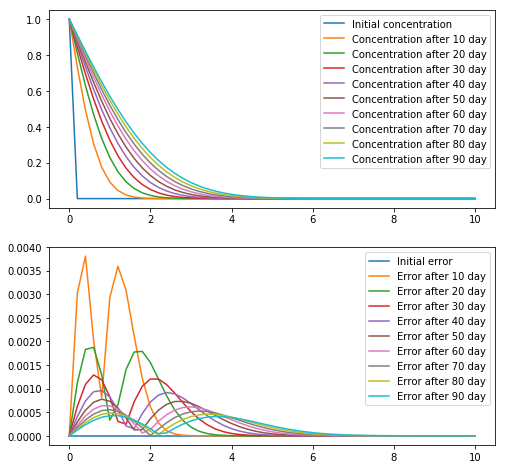

In [26]:
N_x = 51
N_y = 1
Width_X = Width
Width_Y = 0
n = N_x * N_y
x = np.linspace(0, Width, N_x)
c_init = np.zeros(N_x)
c_init[0] = c0
D = Diff * np.ones(n)
poro = 0.4
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros(n)
A, b = Build_2D_Matrix(BC, prob, D, Q)
dt = 0.2
Abis = np.zeros((n, n))
for i in range(n):
    Abis[i,i] = poro/dt
A = A + Abis
# There is no need to update A at every timestep, since the timestep and the porosity are constant.

Bbis = np.zeros(n)

Tf = 100
nTstp = int(Tf / dt)
Number_of_fig = 10
n_of_tstep_before_fig = int(nTstp / Number_of_fig)

c = np.zeros(((n, Number_of_fig)))
err = np.zeros(((n, Number_of_fig)))
c[:, 0] = c_init
nfig = 1
Time = 0
c_real = np.zeros(n)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x, c_init, label="Initial concentration")
ax2.plot(x, err[:, 0], label="Initial error")
v = c_init

for t in range(nTstp - 1):
    for i in range(n):
        Bbis[i] = v[i] * poro / dt
    bb = b + Bbis
    v = np.linalg.solve(A, bb)
    Time = Time + dt
    if (t + 1) % n_of_tstep_before_fig == 0 and t > 0:
        for i in range(n):
            c[i, nfig] = v[i]
            DENOM = np.sqrt(4 * Diff * (t + 1) * dt)
            c_real[i] = c0 * special.erfc((x[i]) / DENOM)
            err[i, nfig] = abs(c[i, nfig] - c_real[i])

        ax1.plot(x, c[:, nfig], label="Concentration after %.0f day" % Time)
        ax2.plot(x, err[:, nfig], label="Error after %.0f day" % Time)
        nfig = nfig + 1


ax1.legend()
ax2.legend()

### Quantification of the error

One may realize that the previous visualization of the error is not particularly helpful. We would like to quantify the error using only one real number, so that comparison is easier. This is the concept of the *norm*. It is defined in "numpy.linalg.norm". The norm of a vector $\overrightarrow{x}$ is usually written

\begin{equation}
\lvert \lvert \overrightarrow{x}\lvert\lvert
\end{equation}

There exists many type of norm

Norm-1:

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_1 = \sum_i^N |x_i|
\end{equation}

Norm-2 (notion of distance)

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_2 = \sqrt{\sum_i^N |x_i|^2}
\end{equation}


The infinte-norm:

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_\infty = max_i  \{ |x_i| \}
\end{equation}

We can also define the n-norm, but the three previous one are most commonly used.

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_n = \sqrt[n]{\sum_i^N |x_i|^n}
\end{equation}

Use the 2nd norm ( np.linalg.norm() ) to see the evolution of the global error with the timestep.

0.008114859270814626


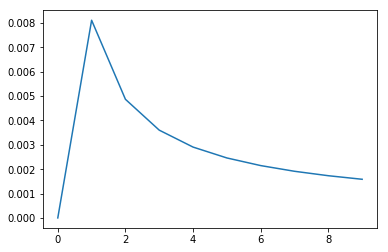

In [41]:
err_norm = np.zeros(nfig)
for i in range(nfig):
    err_norm[i] = np.linalg.norm(err[:, i])

plt.plot(err_norm)
maxerr = max(err_norm)
print(maxerr)

Now see the influence of modifying the number of gridblocks and timestep and choose a good compromise between accuracy, and computation time.

What we want you to do, is to convert one of the previous cell, which does the computation of the solution and the error. That function should return one single real number, representing the norm of the error. We want you to define several timestep and gridsize (4-5 values max for each, otherwise computation time might be too important). So, loop over the different timesteps and gridsize you have chosen, call the function for each situation, and store the return of the function as an error.

In the end, we want you to plot the error in function of the timestep and gridsize, and chose the timestep you think is the best. A good compromise between accuracy and computation time is usually the best. In the rest of the assignment, we will go 2D. So, if your choice from here results in a too high computation time, the 2D calculation will take an important amount of time.

In [42]:
def Compute_error(n,dt):
    """
    Computes the error of the 1D transient diffusion problem
    n is the amount of gridcells in the x-dimension
    dt is the timestep in days
    """ 
    ### BEGIN SOLUTION
    Width_X = 10
    x = np.linspace(0, Width, n)
    c0 = 1
    Diff = 2e-9 * 100 * 24 * 3600
    x = np.linspace(0, Width, n)
    c_init = np.zeros(n)
    c_init[0] = c0
    D = Diff * np.ones(n)
    poro = 0.4
    prob = def_prob(n, 1, poro, Width_X, 0)
    Q = np.zeros(n)
    A, b = Build_2D_Matrix(BC, prob, D, Q)

    Abis = np.zeros((n, n))
    for i in range(n):
        Abis[i,i] = poro/dt
    A = A + Abis
    # There is no need to update A at every timestep, since the timestep and the porosity are constant.

    Bbis = np.zeros(n)
    Tf = 100
    nTstp = int(Tf / dt)
    Number_of_fig = 10
    n_of_tstep_before_fig = int(nTstp / Number_of_fig)

    c = np.zeros(((n, Number_of_fig)))
    err = np.zeros(((n, Number_of_fig)))
    c[:, 0] = c_init
    nfig = 1
    Time = 0
    c_real = np.zeros(n)

    v = c_init

    for t in range(nTstp - 1):
        for i in range(n):
            Bbis[i] = v[i] * poro / dt
        bb = b + Bbis
        v = np.linalg.solve(A, bb)
        Time = Time + dt
        if (t + 1) % n_of_tstep_before_fig == 0 and t > 0:
            for i in range(n):
                c[i, nfig] = v[i]
                DENOM = np.sqrt(4 * Diff * (t + 1) * dt)
                c_real[i] = c0 * special.erfc((x[i]) / DENOM)
                err[i, nfig] = abs(c[i, nfig] - c_real[i])
                
            nfig = nfig + 1

    err_norm = np.zeros(nfig)
    for i in range(nfig):
        err_norm[i] = np.linalg.norm(err[:, i])

    maxerr = max(err_norm)
    ### END  SOLUTION
    return maxerr


In the next cell, we want you to use the previously defined function to compute the error for different values of the number_of_grid_cells and time_steps, and give relevant values (a couple of plots, maybe) to justify your future choice. The next cell gives you an example of how we want you to work.




In [43]:
import time
number_of_grid_cells = 21
time_steps = 0.5

Init_Comp_Time = time.time()
Error = Compute_error(number_of_grid_cells,time_steps)
Time_of_sim = time.time()-Init_Comp_Time

print(f"The error is: {Error}")
print(f"The simulation time was {Time_of_sim}")

The error is: 0.022254669008191983
The simulation time was 0.02983689308166504


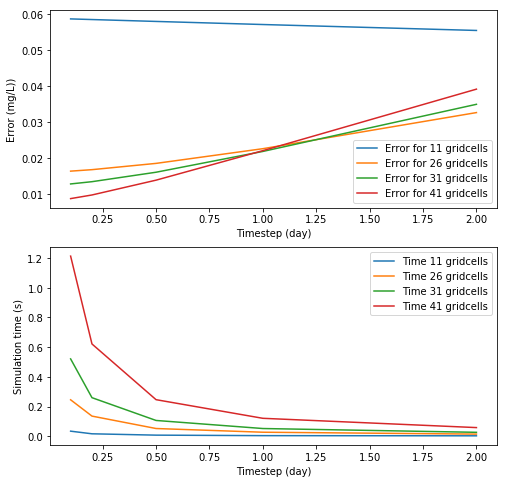

In [66]:
### BEGIN SOLUTION
number_of_grid_cells = np.array([11,26,31, 41])
time_steps = np.array([0.1, 0.2, 0.5, 1, 2])
Sim_time = np.zeros((4,5))
Error = np.zeros((4,5))

for i in range(4):
    for j in range(5):
        Init_Comp_Time = time.time()
        Error[i,j] = Compute_error(number_of_grid_cells[i],time_steps[j])
        Sim_time[i,j] = time.time()-Init_Comp_Time
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))  
for i  in range(4):
    ax1.plot(time_steps,Error[i,:],label="Error for %.0f gridcells" % number_of_grid_cells[i])
    
ax1.set(xlabel="Timestep (day)")
ax1.set(ylabel="Error (mg/L))")
ax1.legend();

for i in range(4):
    ax2.plot(time_steps,Sim_time[i,:],label="Time %.0f gridcells" % number_of_grid_cells[i])
    
ax2.set(xlabel="Timestep (day)")
ax2.set(ylabel="Simulation time (s)")
ax2.legend();       

#From this we can conclude that a good compromise between accuracy and timestep 
# is a timestep of 0.5 day for a number of 26 gridcells (or around that)
N_x = 26
dt = 1
### END SOLUTION


Based on the previous results, you should fix the value of N_x and dt. We will let you decide which value to take, but we are going to test their values so that they are not out of proportion.

In [67]:
N_x = 1000
dt = 0.01
# Change the values given above
### BEGIN SOLUTION
N_x = 26
dt = 1
### END SOLUTION

In [69]:
assert_allclose(abs(N_x-28)/10, 0, atol = 0.8, rtol=0.1)
assert_allclose(abs(dt-1), 0, atol = 0.5, rtol=0.1)

### 2D transient diffusion in homogeneous media

Going from 1 to 2 dimensions changes nothing conceptually. There is, however a couple of changes required for the coding perspective. Indeed, whether the problem is 1D or 2D or 3D, the stucture of the system of equation Ac = b is the same. Matrix $A$ will always be a $n \times n$ matrix, while $c$ and $b$ will always be column vector of size $n$. In 2D, $n = N_x \times N_y$, while in 3D, it will be $n = N_x \times N_y \times N_z$.

But, the fact that in every case, the solution is stored in one vector, representing either a 1/2/3D solution. For a 2D problem, a two-way conversion between vector and matrix is required. To plot the 2D result, for example, we will use colourmap plots, which require the solution to be plotted to be represented as a Matrix.

The function vec2mat(...) (explicitly $vector to matrix$) does this: it converts a vector into the relevant 2D matrix, using N_x and N_y.

The reverse function is usually required to initialize the initial condition. It is mac2vec(...). These two functions are defined here below.

In [47]:
def mat2vec(c, nrow, ncol):
    n = nrow * ncol
    v = np.zeros(n)
    for ind in range(n):
        i, j = ind_to_row_col(ind, nrow, ncol)
        v[ind] = c[i, j]

    return v

In [48]:
def vec2mat(v, nrow, ncol):
    n = 0
    c = np.zeros((nrow, ncol))
    for i in range(nrow):
        for j in range(ncol):
            c[i, j] = v[n]
            n = n + 1
    return c

So, until here, we have defined values for gridsize and timestep which provide a nice compromise between accuracy and computation time. We will use these values in the following.

We could perform the same analysis in 2D for the error. But we will here a focus on a nicer problem, in which there is a zone of very low diffusivity in the middle. We will let you decide which value to put there for diffusion, we will start by a diffusion 100 times lower. You can change that value if you want.

In [49]:
Decreasing_Factor = 0.01 # Feel free to change if you want to see the impact 
# (you can go higher than 1 ... But be careful, if diffusion speeds up significantly, 
# the accuracy with respect to the chosen timestep might not be so good if you speed things up! )
# Initial value is 0.01

In [50]:
Diff_low = Diff*Decreasing_Factor

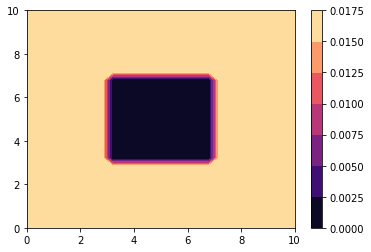

In [90]:
# Here we define the initial condition, and the diffusion matrix for the 2D problem

Width_X = 10
Width_Y = 10
# N_x should be defined by your previous analysis
N_y = N_x 

D = Diff * np.ones((N_y, N_x))
Q = np.zeros((N_y, N_x))
poro = 0.4
dt = 0.25  # days
c_init = np.zeros((N_y, N_x))

x = np.linspace(0, Width_X, N_x)
y = np.linspace(0, Width_Y, N_y)

for i in range(N_y):
    for j in range(N_x):
        if j == 0:
            c_init[i, j] = c0 # Initial c ondition


for i in range(N_y):
    for j in range(N_x):
        if (
            abs(x[j] - Width_X / 2) <= 0.2 * Width_X
            and abs(y[i] - Width_Y / 2) <= 0.2 * Width_Y
        ):
            D[i, j] = Diff_low
            # here we define a square of low diffusivity in the middle

            
fig, ax = plt.subplots()
# This generates a colormap of diffusion.
cm = cmap.get_cmap("magma")
plt.contourf(x, y, D, cmap=cm)
plt.colorbar()
# noqa

# "magma" refers to a colormap example. You can chose other ones
# https://matplotlib.org/examples/color/colormaps_reference.html

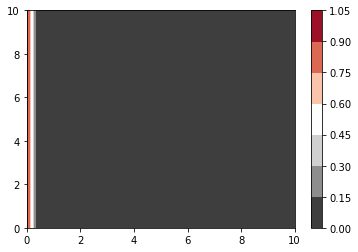

In [114]:
# Here we plot the initial condition using the colormap again
fig, ax = plt.subplots()
# This generates a colormap of diffusion.
cm = cmap.get_cmap("RdGy_r")
plt.contourf(x, y, c_init, cmap=cm)
plt.colorbar()


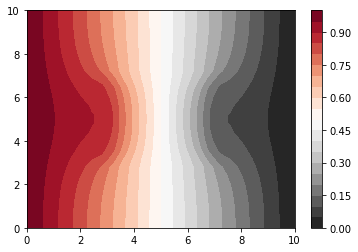

In [138]:
# Here we give you the asymptotic solution to the problem
# we are using everything we have done before

### Asymptotic behavior
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros((N_y, N_x))
A, b = Build_2D_Matrix(BC, prob, D, Q)
v = np.linalg.solve(A, b)
n = N_x*N_y
# array v contains the solution
# we convert it in a matrix:

c = vec2mat(v, N_y, N_x)

# and we plot the matrix
plt.contourf(x, y, c, 20, cmap=cm)
plt.colorbar()

In [54]:
# Provide here a few comments on the asymptotic solution. What does your intuition tell you?
### BEGIN SOLUTION
# the flux is lowered on the central zone which is being avoided, ... just want them to comment
### END SOLUTION

Now we want you to solve the transient problem in the next cell.
Everything you need has been defined 

- the boundary conditions have been defined (BC)
- matrix A and b is known from the solution of the steady-state problem
- every variable, parameter is known, as well as the initial condition in the matrix c_init

We want you to perform a similar timeloop as we did for the 1D problem. We want you to save 9 different timesteps (including the initial one), which will be plotted in the cell after.

You need to initialize v from the initial condition, define the number of timesteps (hence the total duration of the simulation in days), define at which moment you want to save the concentration so that we can plot them later.

We want a simulation representing 800 days. So ideally, you should plot the initial concentration, at 100, 200, 300, ..., 800 days, which represent 9 different plot (already programmed two cells below). The way you chose to save the concentration at these specific time is up to you.

If you struggle organizing exactly plots at the right time, at least provide one plot similar to the one we have generated above.

Be careful, with a high amount of timesteps, it can take a few minutes to run. Start with only a few timesteps to make sure everything is working properly.

If you want to run the simulation until the steady-state is achieved, please do! You are welcome to present any result you want. The last cell is made so 9 different times are plotted. If you can't make it, plot whatever you want in the cell above that one and put the boolean Automated_Plot to false!

In [142]:
Number_of_fig = 9
c = np.zeros(((N_y, N_x, Number_of_fig)))
for i in range(Number_of_fig):
    c[:,:,i] = c_init
Tf = 800
nTstp = int(Tf/dt) # Number of timestep
n_of_tstep_before_fig = int(nTstp/(Number_of_fig-1))


# We will plot the different slices of c in the end. 
# You have to save the values of the solution at certain timesteps in c[:,:,New_timestep]

In [145]:
Automated_plot = True # set that to False if you don't want the automated 9 plots

In [143]:
v = mat2vec(c_init, N_y, N_x)
Abis = np.zeros((n, n))
for i in range(n):
    Abis[i, i] = poro / dt
Aa = A + Abis
Bbis = np.zeros(n)

n_of_tstep_before_fig = int(nTstp/(Number_of_fig-1))

nfig = 1

for t in range(nTstp):
    for i in range(n):
        Bbis[i] = v[i] * poro / dt
    bb = b + Bbis
    v = np.linalg.solve(Aa, bb)
    if (t+1) % n_of_tstep_before_fig == 0:
        c[:, :, nfig] = vec2mat(v, N_y, N_x)
        nfig = nfig + 1
        



1
2
3
4
5
6
7
8


In [ ]:
### If you didn't manage to save the different figures, please plot the result for the final timestep here.
# If not required, you can just delete the error (this answer is worth 0 point, so it's not going to matter.)
### BEGIN SOLUTION

### END SOLUTION

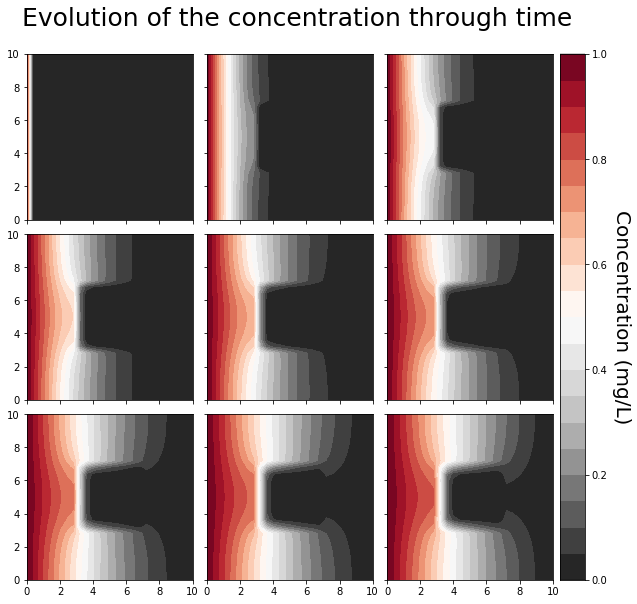

In [148]:
# https://jdhao.github.io/2017/06/11/mpl_multiplot_one_colorbar/
# https://matplotlib.org/tutorials/toolkits/axes_grid.html

if Automated_plot:
    fig = plt.figure(figsize=(10, 10))

    ntimesteps = nfig
    time_steps = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])

    grid = AxesGrid(
        fig,
        111,
        nrows_ncols=(3, 3),
        axes_pad=0.20,
        cbar_mode="single",
        cbar_location="right",
        cbar_pad=0.1,
    )

    for time_index, the_ax in zip(time_steps, grid):
        the_ax.axis("equal")
        im = the_ax.contourf(x, y, c[:, :, time_index], 20, cmap=cm)

    cbar = grid.cbar_axes[0].colorbar(im)
    cbar.set_label_text("Concentration (mg/L)", rotation=270, size=20, va="bottom");
    fig.suptitle("Evolution of the concentration through time", y=0.9, size=25, va="bottom");

##  Conclusions

What you may have noticed, is that, even for small simple 2d transient problems like the one you have just solved, the computation times are already becoming significant... 

This is partly because we are dealing with big matrix which are filled with zeros. It is a complete waste of time and memory to deal with all of these 0 values. There are other ways to make our calculation way faster. We will probably dedicate a lecture to understand how we can improve this. 